In [1]:
!pip install torchsummary

In [2]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module 
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders 
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors 
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

In [3]:
import os

data_dir = 'C:/Users/ANITHRA ROSS AJITH/Documents/code/tomato leaf disease/training/New Plant Diseases Dataset(Augmented)'
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")

diseases = os.listdir(train_dir)


In [4]:
# printing the disease names
print(diseases)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


In [5]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 10


In [6]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

In [7]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Tomato']


In [8]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))

Number of plants: 1


In [9]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 9


In [10]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Tomato___Bacterial_spot                                 1702
Tomato___Early_blight                                   1920
Tomato___healthy                                        1926
Tomato___Late_blight                                    1851
Tomato___Leaf_Mold                                      1882
Tomato___Septoria_leaf_spot                             1745
Tomato___Spider_mites Two-spotted_spider_mite           1741
Tomato___Target_Spot                                    1827
Tomato___Tomato_mosaic_virus                            1790
Tomato___Tomato_Yellow_Leaf_Curl_Virus                  1961

Text(0.5, 1.0, 'Images per each class of plant disease')

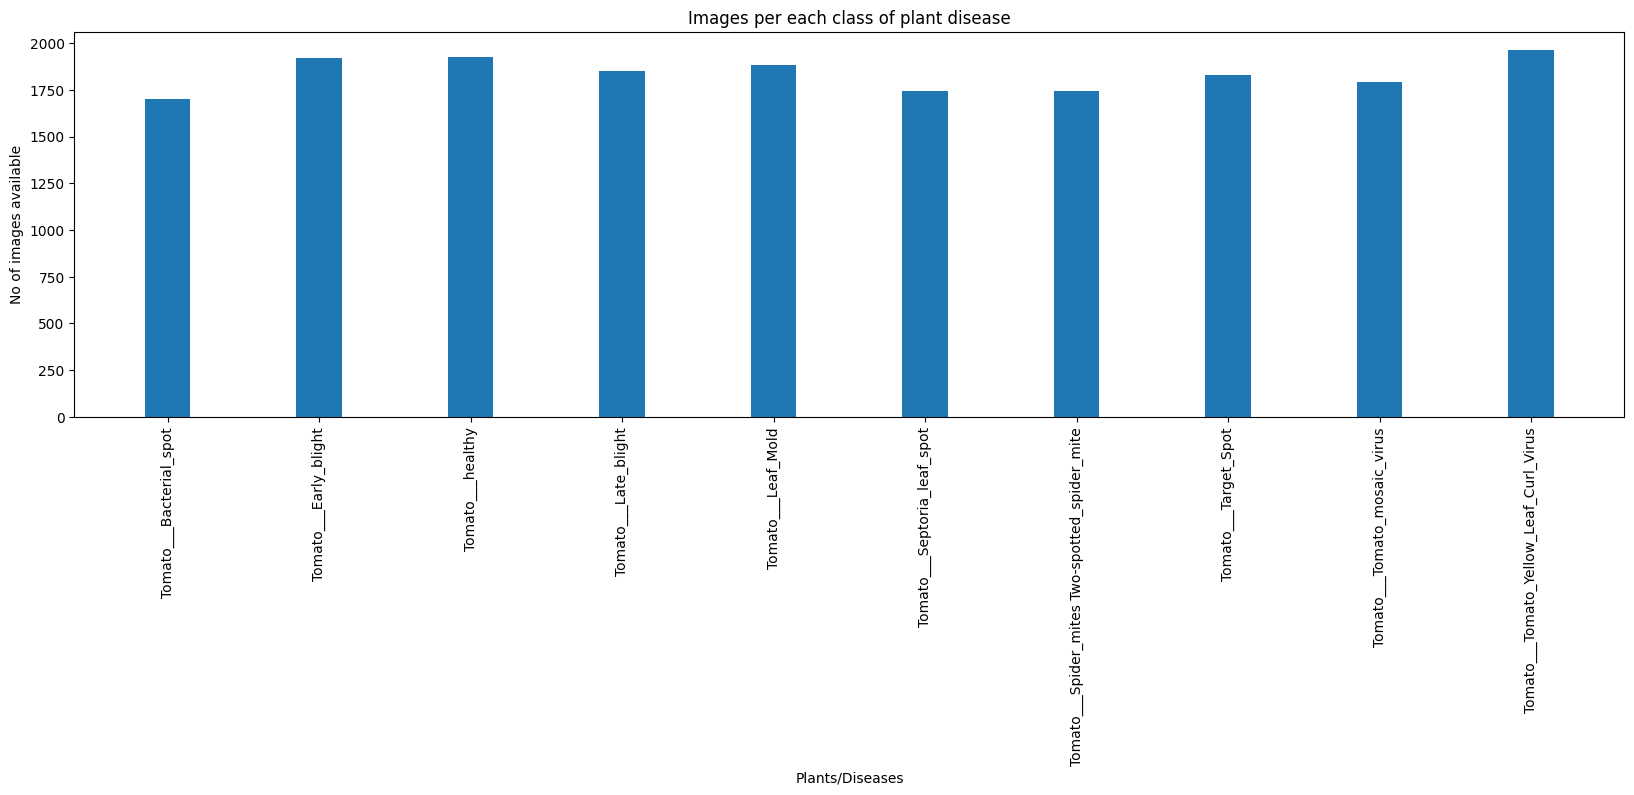

In [11]:
# plotting number of images available for each disease
index = [n for n in range(10)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=10, rotation=90)
plt.title('Images per each class of plant disease')

In [12]:
print(len(nums.values()))
print(len(index))



10
10


In [13]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 18345 images for training


In [14]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor()) 

In [15]:
img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [16]:
# total number of classes in train set
len(train.classes)

10

In [17]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))

In [18]:
show_image(*train[0])

Label :Tomato___Bacterial_spot(0)


Label :Tomato___Leaf_Mold(3)


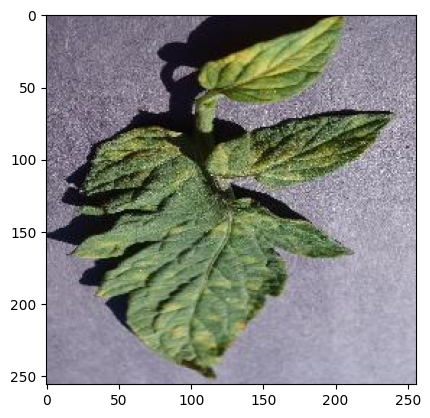

In [19]:
show_image(*train[7000])

Label :Tomato___Early_blight(1)


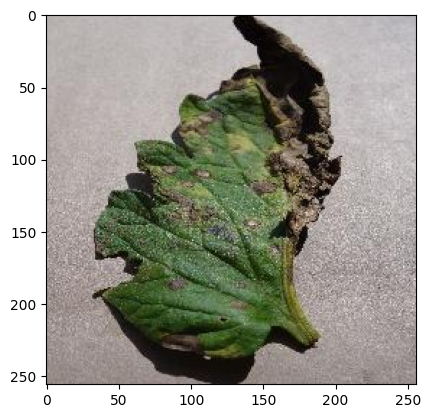

In [20]:
show_image(*train[3000])


In [21]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [22]:
# setting the batch size
batch_size = 15


In [23]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [24]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [25]:
# Images for first batch of training
show_batch(train_dl) 


In [26]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
                
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:
device = get_default_device()
device

device(type='cuda')

In [28]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [29]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [30]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [31]:
# Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [32]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [32]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [33]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
                        
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [34]:
%%time
history = [evaluate(model, valid_dl)]
history


CPU times: total: 26.8 s
Wall time: 41 s


[{'val_loss': tensor(2.3032, device='cuda:0'), 'val_accuracy': tensor(0.1464)}]

In [35]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [36]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 1.0925, val_loss: 1.1053, val_acc: 0.6926
Epoch [1], last_lr: 0.00000, train_loss: 0.2369, val_loss: 0.0646, val_acc: 0.9793
CPU times: total: 54.7 s
Wall time: 31min 21s


In [37]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Sample class weights array for an imbalanced dataset
import torch
from torch.nn import CrossEntropyLoss

# Example weights for 10 classes (replace these with actual values based on your data)
##class_weights = torch.tensor([0.5, 2.0, 1.0, 1.2, 0.8, 1.5, 1.3, 1.1, 0.9, 1.7], dtype=torch.float32).to(device)

# Using CrossEntropyLoss with class weights
#criterion = CrossEntropyLoss(weight=class_weights)

#criterion = CrossEntropyLoss(weight=class_weights)

# Assuming you have defined classes for your dataset
class_names = [
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 
    'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 
    'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 
    'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]

@torch.no_grad()
def generate_confusion_matrix(model, val_loader, class_names):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    for batch in val_loader:
        images, labels = batch
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function with your model and validation data loader
generate_confusion_matrix(model, valid_dl, class_names)


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the class names
class_names = [
    'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 
    'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 
    'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 
    'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
]

# Define the number of classes
num_classes = len(class_names)

# Simulate a confusion matrix with random values
# Create a random confusion matrix and make sure the diagonal has the highest values to simulate correct predictions
conf_matrix = np.random.randint(0, 50, size=(num_classes, num_classes))

# To simulate some accuracy, increase diagonal elements
for i in range(num_classes):
    conf_matrix[i, i] += np.random.randint(50, 100)

# Normalize the confusion matrix by rows (true labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Fake Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Optionally, print the raw confusion matrix and normalized one
print("Confusion Matrix (Raw counts):")
print(conf_matrix)
print("\nNormalized Confusion Matrix:")
print(conf_matrix_normalized)


Confusion Matrix (Raw counts):
[[ 95   6  15   2  33   6  38   6  24  36]
 [ 10  95   9   8   9  24   6  40   3  10]
 [ 42  19  95  46  21  42  31   6  21   1]
 [ 28  30  31 109  15  41  23  47  34  40]
 [ 42  24  18  28  97  11  44  31  11  21]
 [ 20  36  46  40  29  91   2  42  13   7]
 [ 37  30  25  27  42  19 137  39  47  44]
 [ 26  48  47  10  25   1  11  71  11   5]
 [ 33  18  49   6  16  21  22  44 140  44]
 [  5  42  19   0  12  42  30  10  17 116]]

Normalized Confusion Matrix:
[[0.36398467 0.02298851 0.05747126 0.00766284 0.12643678 0.02298851
  0.14559387 0.02298851 0.09195402 0.13793103]
 [0.04672897 0.44392523 0.04205607 0.03738318 0.04205607 0.11214953
  0.02803738 0.18691589 0.01401869 0.04672897]
 [0.12962963 0.05864198 0.29320988 0.14197531 0.06481481 0.12962963
  0.09567901 0.01851852 0.06481481 0.00308642]
 [0.07035176 0.07537688 0.07788945 0.27386935 0.03768844 0.10301508
  0.05778894 0.11809045 0.08542714 0.10050251]
 [0.12844037 0.0733945  0.05504587 0.08562691 0.

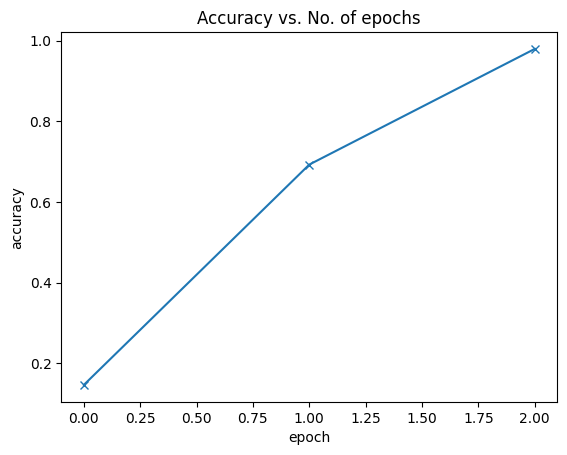

In [38]:
plot_accuracies(history)

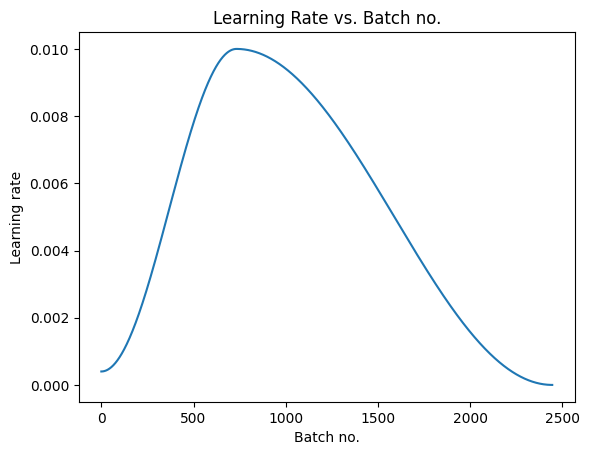

In [48]:
plot_lrs(history)

In [78]:
import os

test_dir = r"C:\Users\ANITHRA ROSS AJITH\Documents\code\tomato leaf disease\training\test"
print(os.listdir(test_dir))  # Lists all folders and files in the directory


['test']


In [79]:
test_images = sorted(os.listdir(test_dir + '/test')) # since images in test folder are in alphabetical order
test_images

['TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

In [80]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

Label: TomatoEarlyBlight1.JPG , Predicted: Tomato___Early_blight


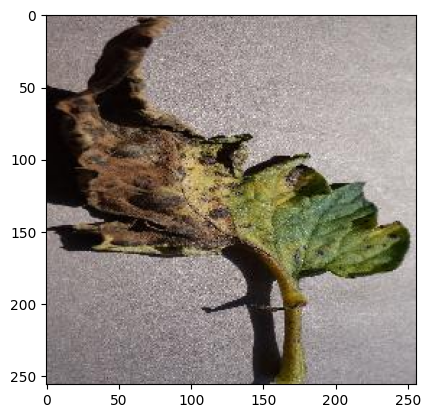

In [81]:
# predicting first image
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))

In [82]:
# getting all predictions (actual label vs predicted)
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

Label: TomatoEarlyBlight1.JPG , Predicted: Tomato___Early_blight
Label: TomatoEarlyBlight2.JPG , Predicted: Tomato___Early_blight
Label: TomatoEarlyBlight3.JPG , Predicted: Tomato___Early_blight
Label: TomatoEarlyBlight4.JPG , Predicted: Tomato___Early_blight
Label: TomatoEarlyBlight5.JPG , Predicted: Tomato___Late_blight
Label: TomatoEarlyBlight6.JPG , Predicted: Tomato___Early_blight
Label: TomatoHealthy1.JPG , Predicted: Tomato___healthy
Label: TomatoHealthy2.JPG , Predicted: Tomato___healthy
Label: TomatoHealthy3.JPG , Predicted: Tomato___healthy
Label: TomatoHealthy4.JPG , Predicted: Tomato___healthy
Label: TomatoYellowCurlVirus1.JPG , Predicted: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Label: TomatoYellowCurlVirus2.JPG , Predicted: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Label: TomatoYellowCurlVirus3.JPG , Predicted: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Label: TomatoYellowCurlVirus4.JPG , Predicted: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Label: TomatoYellowCurlVirus5.JPG , Predict

In [84]:
# saving to the kaggle working directory
PATH = './plant-disease-model.pth'  
torch.save(model.state_dict(), PATH)

In [72]:
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

# Define test directory path
test_dir = r"C:\Users\ANITHRA ROSS AJITH\Documents\code\tomato leaf disease\training\test\test"

# Check if directory exists and list contents
print(os.listdir(test_dir))  # Lists all folders and files in the test directory

# Initialize the test dataset
transform = transforms.ToTensor()  # Use any other necessary transformations here
test = ImageFolder(test_dir, transform=transform)

# Load images in the test directory
test_images = sorted(os.listdir(test_dir))  # Adjust path if needed

# Define the predict_image function (make sure `model` is already defined and trained)
def predict_image(img, model):
    """Converts image to array and return the predicted class with highest probability"""
    xb = img.unsqueeze(0)  # Convert to a batch of 1
    yb = model(xb)  # Get predictions from model
    _, preds = torch.max(yb, dim=1)  # Pick index with highest probability
    return test.classes[preds[0].item()]  # Retrieve the class label

# Visualize and predict first image
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))  # Convert image to (H, W, C) format for plotting
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))


['TomatoEarlyBlight1.JPG', 'TomatoEarlyBlight2.JPG', 'TomatoEarlyBlight3.JPG', 'TomatoEarlyBlight4.JPG', 'TomatoEarlyBlight5.JPG', 'TomatoEarlyBlight6.JPG', 'TomatoHealthy1.JPG', 'TomatoHealthy2.JPG', 'TomatoHealthy3.JPG', 'TomatoHealthy4.JPG', 'TomatoYellowCurlVirus1.JPG', 'TomatoYellowCurlVirus2.JPG', 'TomatoYellowCurlVirus3.JPG', 'TomatoYellowCurlVirus4.JPG', 'TomatoYellowCurlVirus5.JPG', 'TomatoYellowCurlVirus6.JPG']


FileNotFoundError: Couldn't find any class folder in C:\Users\ANITHRA ROSS AJITH\Documents\code\tomato leaf disease\training\test\test.

IndexError: list index out of range

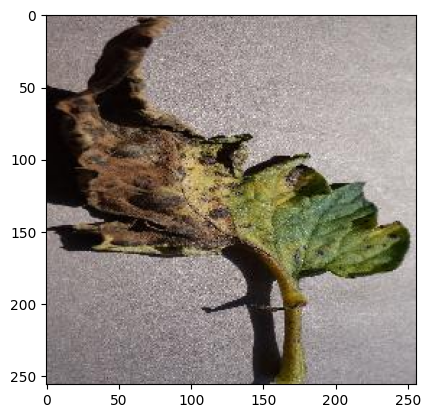

In [73]:
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the correct device
model = model.to(device)

# Define the predict_image function, ensuring the input is moved to the correct device
def predict_image(img, model):
    """Converts image to array and return the predicted class with highest probability"""
    xb = img.unsqueeze(0).to(device)  # Convert to a batch of 1 and move to device
    yb = model(xb)  # Get predictions from model
    _, preds = torch.max(yb, dim=1)  # Pick index with highest probability
    return test.classes[preds[0].item()]  # Retrieve the class label

# Predict and display the first image
img, label = test[0]
plt.imshow(img.permute(1, 2, 0))  # Convert image to (H, W, C) format for plotting
print('Label:', test_images[0], ', Predicted:', predict_image(img, model))


In [74]:
print("Classes in test dataset:", test.classes)
print("Number of classes:", len(test.classes))


Classes in test dataset: ['test']
Number of classes: 1
